In [180]:
from transformers import BertTokenizer,BertConfig
import os
os.environ['https_proxy'] = "http://192.168.235.34:7890"
os.environ['http_proxy'] = "http://192.168.235.34:7890"
# 加载预训练的BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 示例数据
data = [{'text': 'I dislike rainy days.', 'label': 0},
# {'text': 'I dislike sunny days.', 'label': 0},
# {'text': 'I dislike cloudy days.', 'label': 0},
# {'text': 'I dislike windy days.', 'label': 0},
# {'text': 'I dislike snowy days.', 'label': 0},
{'text': 'I dislike rainy nights.', 'label': 0},
{'text': 'I dislike rainy evenings.', 'label': 0},
{'text': 'I dislike rainy mornings.', 'label': 0},
{'text': 'I dislike rainy afternoons.', 'label': 0},
# {'text': 'I like rainy days.', 'label': 1},
{'text': 'I like sunny days.', 'label': 1},
# {'text': 'I like cloudy days.', 'label': 1},
# {'text': 'I like windy days.', 'label': 1},
# {'text': 'I like snowy days.', 'label': 1},
{'text': 'I like sunny nights.', 'label': 1},
{'text': 'I like sunny evenings.', 'label': 1},
{'text': 'I like sunny mornings.', 'label': 1},
{'text': 'I like sunny afternoons.', 'label': 1},
]

# 数据预处理函数
def preprocess_data(data):
    texts = [item['text'] for item in data]
    labels = [item['label'] for item in data]

    # 使用BERT tokenizer进行编码
    encodings = tokenizer(texts, truncation=True, padding=True)
    return encodings, labels

encodings, labels = preprocess_data(data)


/opt/conda/envs/easyedit/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [184]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertForSequenceClassification, AdamW

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 创建数据集和数据加载器
dataset = TextDataset(encodings, labels)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# 加载预训练的BERT模型并修改为分类任务
config = BertConfig.from_pretrained('bert-base-uncased', output_attentions=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
model.to(device)
# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)


/opt/conda/envs/easyedit/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/envs/easyedit/lib/python3.9/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [182]:
from transformers import get_scheduler
from tqdm.notebook import tqdm
# 设置训练参数
num_epochs = 0
num_training_steps = num_epochs * len(dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

# 将模型移动到GPU（如果可用）
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# 训练循环
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        if epoch % 20 == 0:
            print(loss.item()) 
print("Training completed.")


  0%|          | 0/5 [00:00<?, ?it/s]

0.7811002135276794
0.813167154788971
0.695779025554657
0.8053944110870361
0.6388881802558899
Training completed.


Accuracy: 0.5
torch.Size([12, 12, 7, 7])
(1, 7)


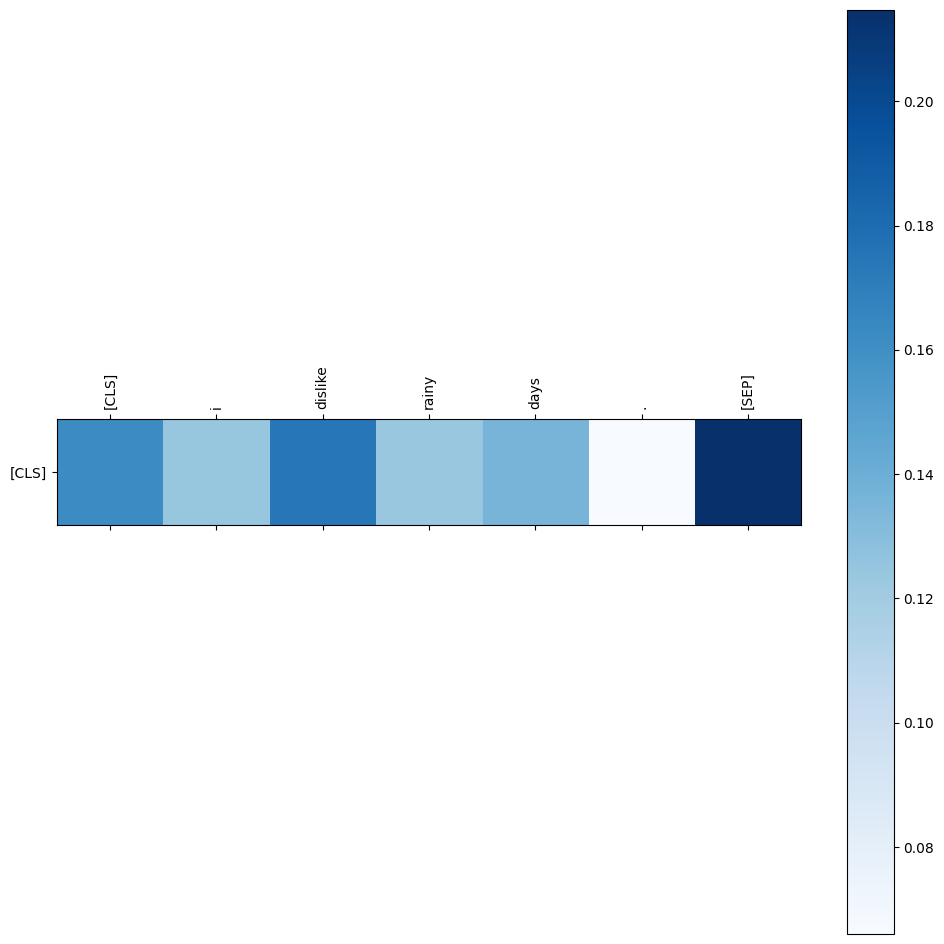

torch.Size([12, 12, 7, 7])
(1, 7)


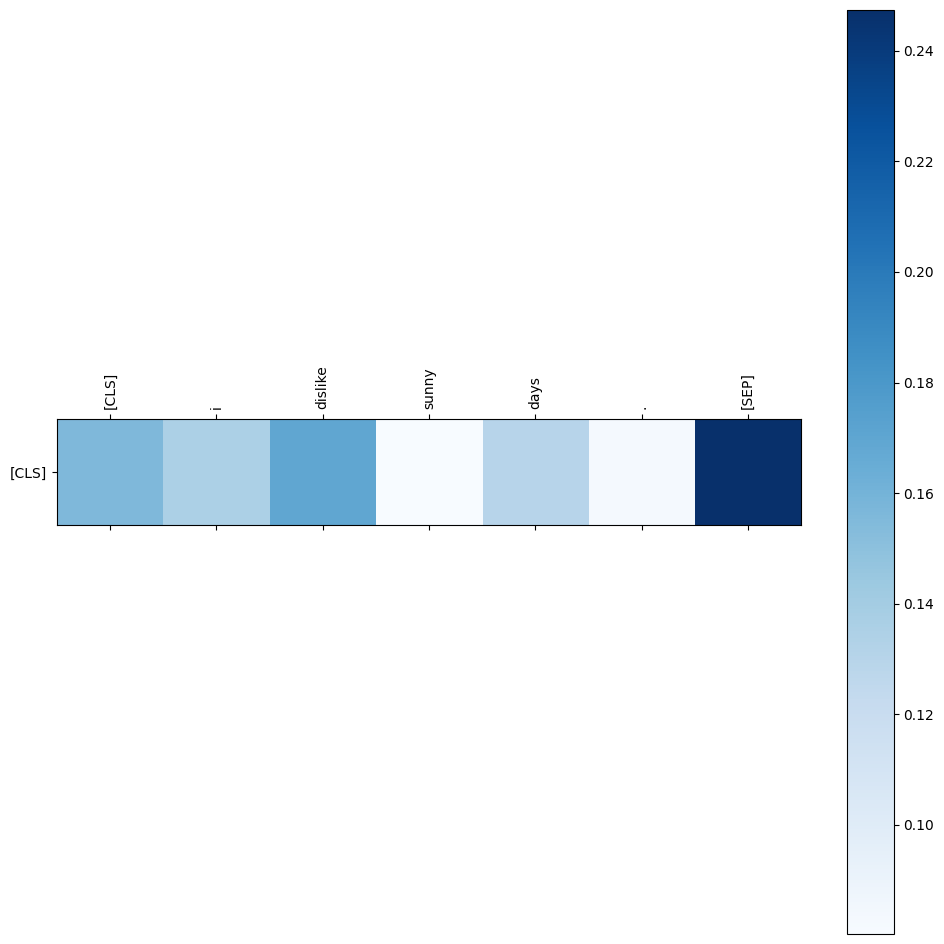

torch.Size([12, 12, 7, 7])
(1, 7)


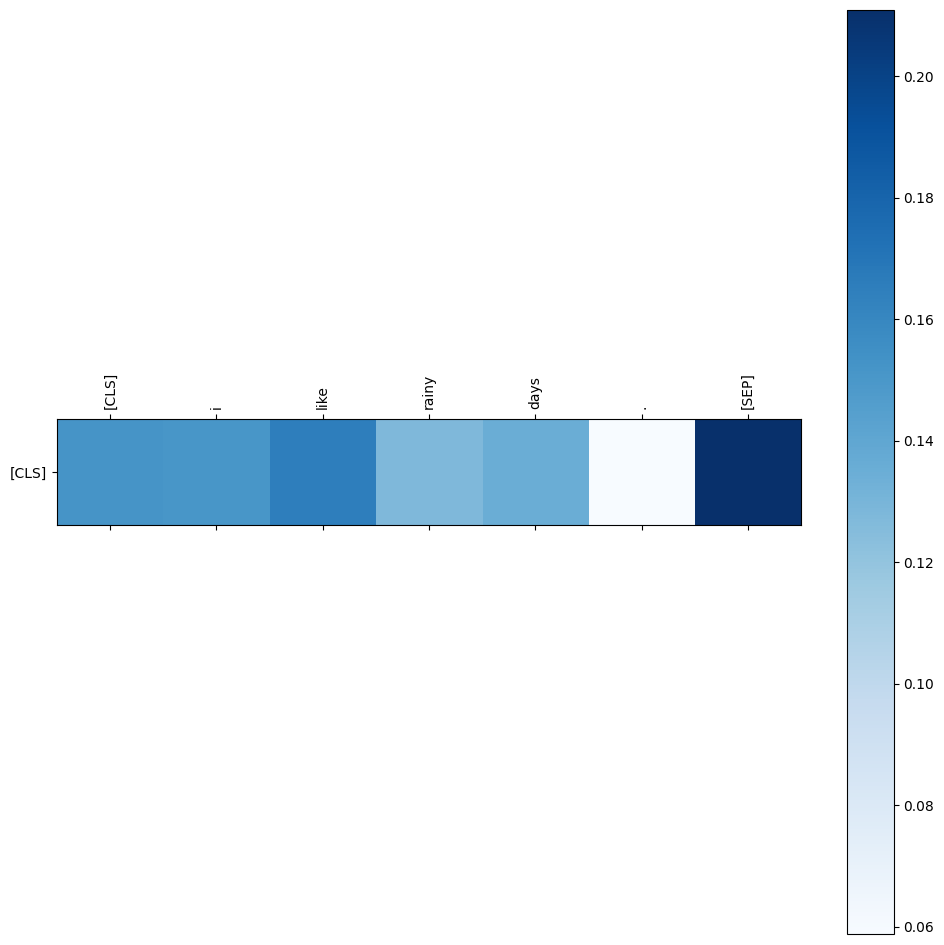

torch.Size([12, 12, 7, 7])
(1, 7)


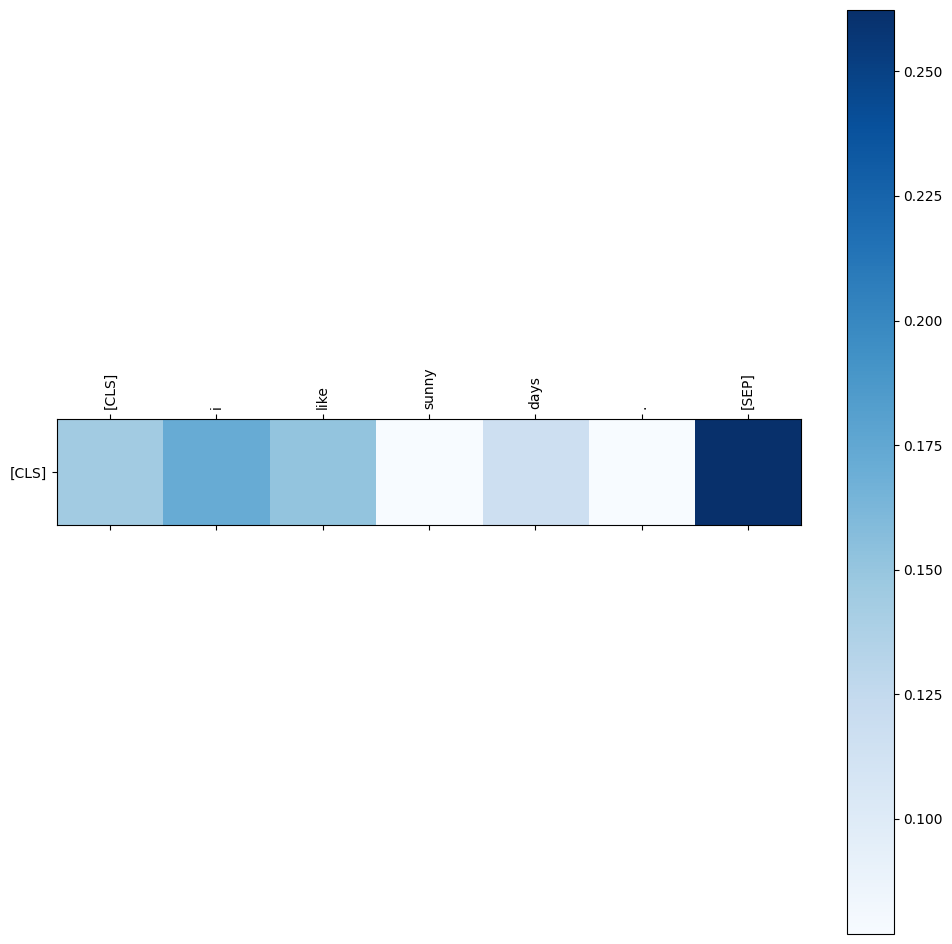

In [185]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
# 评估数据
eval_data = [{'text': 'I dislike rainy days.', 'label': 0},
{'text': 'I dislike sunny days.', 'label': 0},
{'text': 'I dislike cloudy days.', 'label': 0},
{'text': 'I dislike windy days.', 'label': 0},
{'text': 'I dislike snowy days.', 'label': 0},
{'text': 'I dislike rainy nights.', 'label': 0},
{'text': 'I dislike rainy evenings.', 'label': 0},
{'text': 'I dislike rainy mornings.', 'label': 0},
{'text': 'I dislike rainy afternoons.', 'label': 0},
{'text': 'I like rainy days.', 'label': 1},
{'text': 'I like sunny days.', 'label': 1},
{'text': 'I like cloudy days.', 'label': 1},
{'text': 'I like windy days.', 'label': 1},
{'text': 'I like snowy days.', 'label': 1},
{'text': 'I like rainy nights.', 'label': 1},
{'text': 'I like rainy evenings.', 'label': 1},
{'text': 'I like rainy mornings.', 'label': 1},
{'text': 'I like rainy afternoons.', 'label': 1},
]

eval_data = [{'text': 'I dislike rainy days.', 'label': 0},
{'text': 'I dislike sunny days.', 'label': 0},
# # {'text': 'I dislike cloudy days.', 'label': 0},
# # {'text': 'I dislike windy days.', 'label': 0},
# # {'text': 'I dislike snowy days.', 'label': 0},
# {'text': 'I dislike rainy nights.', 'label': 0},
# {'text': 'I dislike rainy evenings.', 'label': 0},
# {'text': 'I dislike rainy mornings.', 'label': 0},
# {'text': 'I dislike rainy afternoons.', 'label': 0},
{'text': 'I like rainy days.', 'label': 1},
{'text': 'I like sunny days.', 'label': 1},
# {'text': 'I like cloudy days.', 'label': 1},
# {'text': 'I like windy days.', 'label': 1},
# {'text': 'I like snowy days.', 'label': 1},
# {'text': 'I like sunny nights.', 'label': 1},
# {'text': 'I like sunny evenings.', 'label': 1},
# {'text': 'I like sunny mornings.', 'label': 1},
# {'text': 'I like sunny afternoons.', 'label': 1},
]

# 预处理评估数据
eval_encodings, eval_labels = preprocess_data(eval_data)
eval_dataset = TextDataset(eval_encodings, eval_labels)
eval_dataloader = DataLoader(eval_dataset, batch_size=1)

model.eval()
predictions, true_labels = [], []
attention_scores = []

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
    true_labels.extend(batch['labels'].cpu().numpy())
    attention_scores.append(outputs.attentions)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")

# 可视化Attention Scores
def plot_attention_scores(attention_scores, sentence, layer_num=-1, head_num=0):
    # print(attention_scores)
    attention_scores = torch.cat(attention_scores,0)
    print(attention_scores.shape)
    scores = attention_scores[layer_num].mean(0).cpu().numpy()[:1]
    print(scores.shape)
    tokens = tokenizer.tokenize(sentence)
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    
    fig, ax = plt.subplots(figsize=(12, 12))
    cax = ax.matshow(scores, cmap='Blues')
    
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(1))
    
    ax.set_xticklabels(tokens, rotation=90)
    ax.set_yticklabels(['[CLS]'])
    
    fig.colorbar(cax)
    plt.show()

# 可视化每个句子的Attention Scores
for i, data in enumerate(eval_data):
    plot_attention_scores(attention_scores[i], data['text'])